# Breast Cancer Detection
**Sanjif Rajaratnam**

Dataset: <url>https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)</url>

Breast cancer detection using machine learning.

### Import libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,  roc_curve, auc

from scipy import interp

sns.set_style('whitegrid')

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load data

In [2]:
bcw_columns = ['id','clump_thickness','cell_size_uniformity',
               'cell_shape_uniformity','marginal_adhesion',
               'single_epithelial_cell_size',
               'bare_nuclei','bland_chromatin',
               'normal_nuclei','mitoses','class']

In [3]:
bcwDF = pd.read_csv('data/raw/breast-cancer-wisconsin.data', names=bcw_columns)
bcwDF.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Data Cleaning

Here the data will be cleaned as necessary.

In [4]:
bcwDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                             699 non-null int64
clump_thickness                699 non-null int64
cell_size_uniformity           699 non-null int64
cell_shape_uniformity          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    699 non-null object
bland_chromatin                699 non-null int64
normal_nuclei                  699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


From above, there are no nulls but the type of bare nuclei is object so it likely contains not ints

In [5]:
bcwDF['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

From the above, the only non-int is the ?. So let's look at the heatmap distribution:

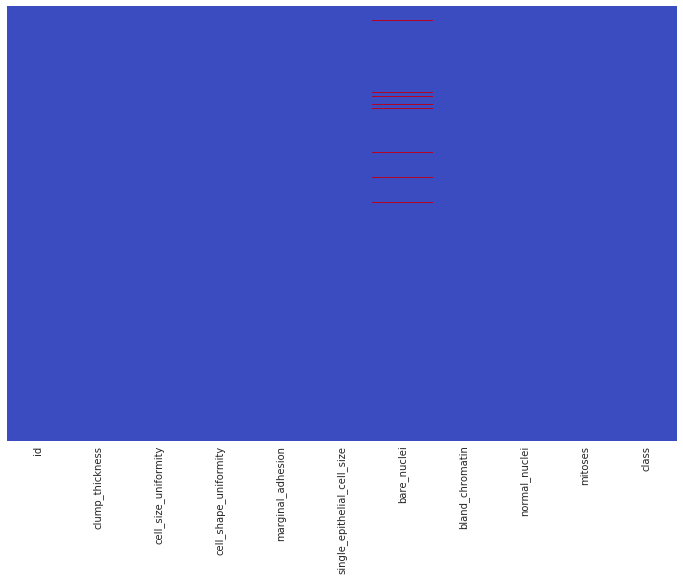

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(bcwDF == '?', cmap='coolwarm', yticklabels=False,cbar=False,ax=ax)

In [7]:
nans = bcwDF[bcwDF['bare_nuclei'] == '?']
nans.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2


In [8]:
print('Total number of samples with missing values:', len(nans))
print('Percentage of samples with missing values', round(len(nans)/len(bcwDF)*100,2),'%')

Total number of samples with missing values: 16
Percentage of samples with missing values 2.29 %


So there are 16 samples with missing values and this represents 2.3% of the total data. Let's see if we can fill this is any manner by viewing the distribution.

Text(0.5,1,'Bare Nuclei Count Plot')

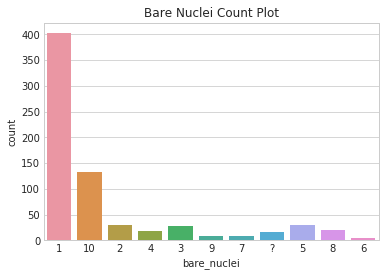

In [9]:
sns.countplot(bcwDF['bare_nuclei'])
plt.title('Bare Nuclei Count Plot')

In [10]:
bcwDF['bare_nuclei'].value_counts().head()

1     402
10    132
5      30
2      30
3      28
Name: bare_nuclei, dtype: int64

In [11]:
bcwDF['bare_nuclei'].value_counts().head() / len(bcwDF)

1     0.575107
10    0.188841
5     0.042918
2     0.042918
3     0.040057
Name: bare_nuclei, dtype: float64

From the distribution, 57.5% of the samples of bare nuclei of 1. By assigning this value to the missing cells, the distribution should change that much.

In [12]:
bcwDF.set_value(bcwDF['bare_nuclei'] == '?', 'bare_nuclei', 1)
bcwDF['bare_nuclei'] = bcwDF['bare_nuclei'].astype(int)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


This is how much the distribution changed:

In [13]:
bcwDF['bare_nuclei'].value_counts().head() / len(bcwDF)

1     0.597997
10    0.188841
5     0.042918
2     0.042918
3     0.040057
Name: bare_nuclei, dtype: float64

### Drop unneccessary feature
Here the id column will be dropped as it likely won't provide meaningful information in predicting the target.

In [14]:
bcwDF = bcwDF.drop('id',axis=1)

### Categorical / numerical feature check
Lastly, check if any of the columns are binary:

In [15]:
for col in bcwDF.columns.values:
    print(col, bcwDF[col].nunique())

clump_thickness 10
cell_size_uniformity 10
cell_shape_uniformity 10
marginal_adhesion 10
single_epithelial_cell_size 10
bare_nuclei 10
bland_chromatin 10
normal_nuclei 10
mitoses 9
class 2


Each variable has over roughly 10 types so I will assume they are linearly releated.

### Convert class to binary

In [23]:
bcwDF['class'] = bcwDF['class'].apply(lambda x: 1 if x == 4 else 0)

Sanity check:

In [24]:
bcwDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
clump_thickness                699 non-null int64
cell_size_uniformity           699 non-null int64
cell_shape_uniformity          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    699 non-null int64
bland_chromatin                699 non-null int64
normal_nuclei                  699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10)
memory usage: 54.7 KB


Save the processed dataframe.

In [34]:
bcwDF.to_csv('data/processed/bcw.csv',index=False)

## Data Exploration

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.5/dist-packages/numpy/co

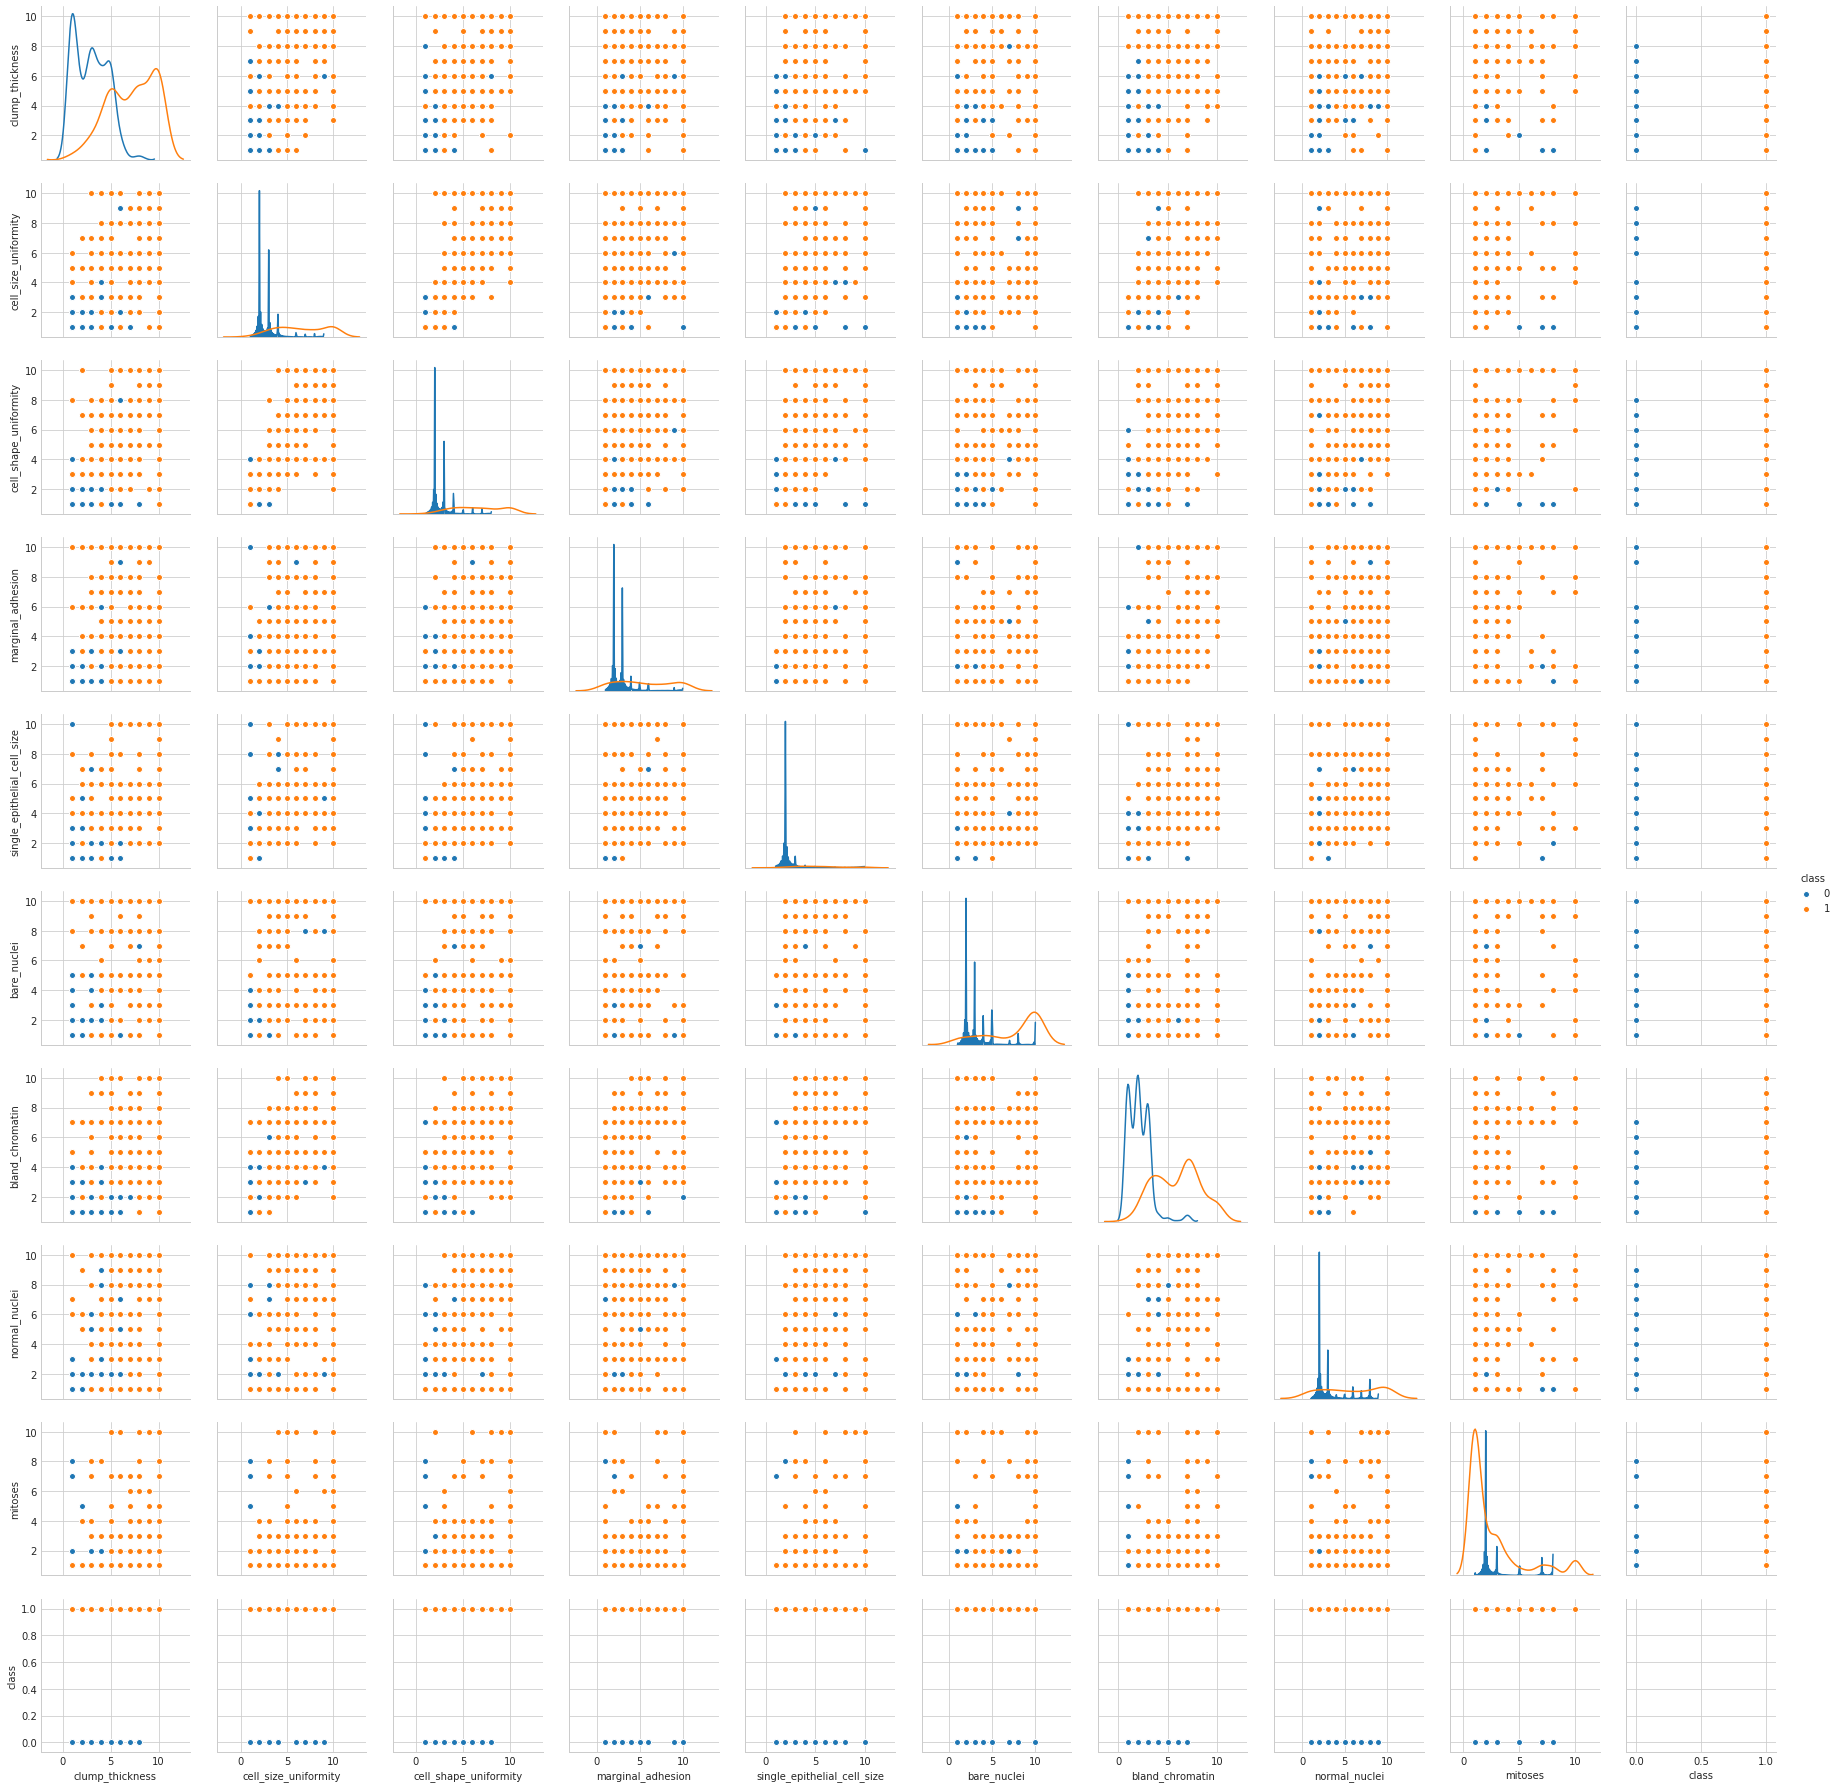

In [25]:
sns.pairplot(bcwDF, hue='class',diag_kind='kde')

In [26]:
bcwDF.head()

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


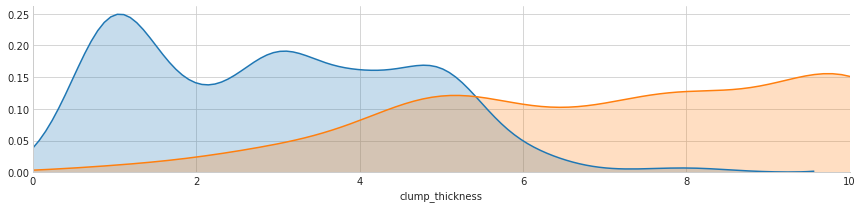

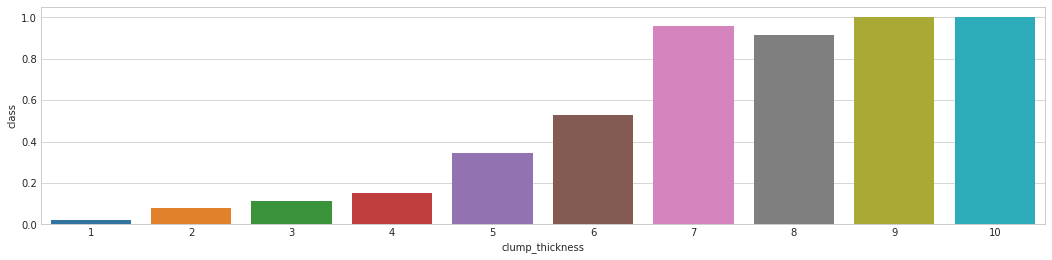

In [27]:
facet = sns.FacetGrid(bcwDF, hue='class', aspect=4)
facet.map(sns.kdeplot, 'clump_thickness', shade=True)
facet.set(xlim=(0, bcwDF['clump_thickness'].max()))

fig, ax = plt.subplots(1,1,figsize=(18,4))
ct_mean = bcwDF[['clump_thickness','class']].groupby(['clump_thickness'],as_index=False).mean()

sns.barplot(x='clump_thickness', y='class', data=ct_mean)

There is fairly clear separation between the classes with lower clump thickness likely indicating a negative prognosis.

## Machine Learning
Grab the features and the target.

In [28]:
X = bcwDF.drop(['class'],axis=1).astype(float)
y = bcwDF['class']

In [29]:
resultDF = pd.DataFrame(columns=['model','hyperparams','train_acc','train_std','test_acc','test_std'])
df_idx = 0

In [35]:
nb = GaussianNB()
svc = SVC(C=100, probability=True, gamma='auto')
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100, solver='lbfgs')#, random_state=seed)
nn = MLPClassifier((80, 10), early_stopping=False)#, random_state=seed)
gb = GradientBoostingClassifier(n_estimators=100)#, random_state=seed)
rf = RandomForestClassifier(n_estimators=10, max_features=3)#, random_state=seed)
dt = DecisionTreeClassifier()
ab = AdaBoostClassifier()

models = {'svm': svc,
          'knn': knn,
          'gnb': nb,
          'nn': nn,
          'rf': rf,
          'gb': gb,
          'log': lr,
          'ab': ab,
          'dt': dt,
        }

In [36]:
def crossValidate(typ, model, X, y, hyperparams='default', verbose=0):
    global df_idx
    
    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    
    # Initialize scaler class
    scaler = StandardScaler()
    
    # Get kFolds
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X)

    # Initialize storage vectors
    trainACC = np.zeros(10)
    testACC = np.zeros(10)
    np_idx = 0

    # Loop through folds
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        # Scale data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit to training set
        model.fit(X_train, y_train)

        # Make predictions on testing set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute training and testing accuracy
        trainACC[np_idx] = accuracy_score(y_train, y_train_pred)*100
        testACC[np_idx] = accuracy_score(y_test, y_test_pred)*100
        np_idx += 1
        
        # Print fold accuracy if verbose level 2
        if verbose == 2:
            print ("    Fold {}: Accuracy: {}%".format(np_idx, round(testACC[-1],3)))   

    # Print average accuracy if verbose level 1
    if verbose == 1:
        print ("  Average Score: {}%({}%)".format(round(np.mean(testACC),3),round(np.std(testACC),3)))
    
    # Update dataframe
    resultDF.loc[df_idx, 'model'] = typ
    resultDF.loc[df_idx, 'hyperparams'] = str(hyperparams)
    resultDF.loc[df_idx, 'train_acc'] = trainACC.mean()
    resultDF.loc[df_idx, 'train_std'] = trainACC.std()
    resultDF.loc[df_idx, 'test_acc'] = testACC.mean()
    resultDF.loc[df_idx, 'test_std'] = testACC.std()
    df_idx += 1                                         
                                         
    # Return average testing accuracy, and fitted model
    return testACC.mean(), model

In [ ]:
load_existing_models = True

In [37]:
if not load_existing_models:
    for name, m in models.items():
        print ("Fitting " + name + " model")
        _, models[name] = crossValidate(name, m, X, y, 'default', 1)
else:    
    resultsDF = pd.read_csv('results.csv')
    for name in models.keys():
        with open(name + '.sav','rb') as f:
            models[name] = pickle.load(f)    

Fitting rf model
  Average Score: 95.567%(3.406%)
Fitting knn model
  Average Score: 95.853%(4.161%)
Fitting log model
  Average Score: 96.571%(3.393%)
Fitting gb model
  Average Score: 95.714%(4.607%)
Fitting nn model


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

  Average Score: 95.857%(4.757%)
Fitting svm model
  Average Score: 94.28%(4.561%)
Fitting ab model
  Average Score: 95.284%(4.041%)
Fitting gnb model
  Average Score: 95.996%(2.694%)
Fitting dt model
  Average Score: 92.563%(4.812%)


In [39]:
resultDF = resultDF.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
log,default,96.884498,0.409155,96.571429,3.392669
knn,default,97.329573,0.387696,96.283644,3.998822
gnb,default,96.010170,0.305434,95.995859,2.693696
nn,default,98.760088,0.526408,95.857143,4.757379
gb,default,100.000000,0.000000,95.714286,4.607004
rf,default,99.825144,0.111291,95.569358,4.305652
ab,default,98.601282,0.501305,95.283644,4.041457
svm,default,100.000000,0.000000,94.279503,4.560584
dt,default,100.000000,0.000000,92.563147,4.812057


In [40]:
def plot_roc_curve(name, model, X, y):
    # Initialize scaler
    scaler = StandardScaler()
    
    # Get kfolds
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X)

    # Initalize storage lists
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    # Loop through folds
    for train_idx, test_idx in kfold.split(X):
        # Split data
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        # Scale data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit model to fold
        model.fit(X_train, y_train)
        
        # Get probabilities for X_test
        y_test_proba = model.predict_proba(X_test)
        
        # Get FPR, TPR, and AUC vals based on probabilities
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:,1])
        roc_auc = auc(fpr, tpr)
        
        # Append tpr and auc
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
     
        # Plot roc for fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        i += 1
    
    # Plot random guessing line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    
    # Get mean tpr and mean/std for auc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean curve
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Fill area between plots
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # style
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: Matplo

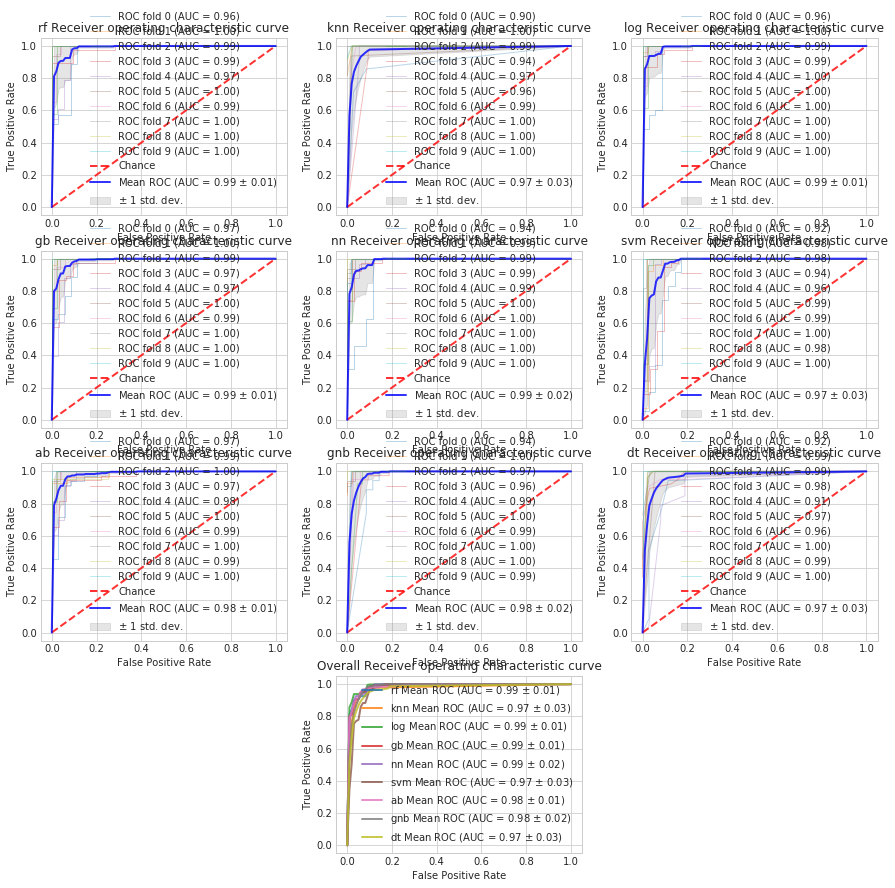

In [54]:
plt_id = 1
plt.figure(figsize=(15,15))
for name, m in models.items():
    ax = plt.subplot(4,3,plt_id)

    fpr, tpr, auc_mean, auc_std = plot_roc_curve(name, m, X, y)
    plt_id+=1
    
    ax = plt.subplot(4,3,11)
    plt.plot(fpr, tpr, label=name + r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (auc_mean, auc_std),
             lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [42]:
def gridSearch(name, models, param_grids, X, y, num_trials=100, verbose=0):
    # Get model and param grid
    model = models[name]
    current_param_grid = param_grids[name]
    
    # Create variable to store best model
    best_model = model    
    
    # Loop through trials
    for nTrial in range(num_trials):
        if verbose == 2 and nTrial % 10 == 0:
            print ('  Trial: %d' % (nTrial))
            
        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF[resultDF['model'] == name]['test_acc'].max()
        
        # Randomly select params from grid
        params = {}
        for k, v in current_param_grid.items():
            params[k] = np.random.choice(v)
        
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = crossValidate(name, model, X, y, params, 0)
                
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
            best_model = model
    # Return best model
    return best_model

In [44]:
param_grids = {}
param_grids['knn'] = {"n_neighbors": np.arange(1,11,1)}
param_grids['log'] = {'C': [0.001,0.01,0.1,1,10,100],
                      'solver':['newton-cg','lbfgs','liblinear','sag']}
param_grids['svm'] = {'C': [0.001,0.001,0.1,1,10,100], 'gamma':[1,2,3,4,5,6,7],
                              'degree': [3,4,5,6]}
param_grids['dt'] = {'criterion': ['gini','entropy'],
                     'max_depth': np.arange(1,6,1),
                     'min_samples_split': np.arange(3,10,1),
                     'max_features': np.arange(1,6,1)
                     }
param_grids['rf'] =  {'n_estimators': [int(x) for x in np.arange(10,2000,10)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,7)] + [None],
                      'min_samples_split': [2,5,10],
                      'min_samples_leaf': [1,2,4],
                      'bootstrap': [True,False]
                      }
param_grids['ab'] = {'n_estimators': [50,100,150,300,500,1000],
                    'learning_rate': [0.001,0.01,0.1,1,2]}
param_grids['gnb'] = {}
param_grids['gb'] = {'n_estimators': [int(x) for x in np.arange(10,2000,10)]}
param_grids['nn'] = {'alpha': [1e-4,1e-3,1e-2,1e-1], 'hidden_layer_sizes': [(20,10),(80,10),(10,20,20,10),(10,10,10),(64,64,64),(64,64,64,64),(16,32,64,64,32,16),(32,32,32,32,32,32)]}


In [45]:
for name in models.keys():
    print (name)
    models[name] = gridSearch(name, models, param_grids, X, y, 50, 1)

rf
    New best rf model: 96.4265010351967
    New best rf model: 96.56935817805382
    New best rf model: 96.71221532091099
    New best rf model: 96.99792960662526
knn
    New best knn model: 96.28571428571429
    New best knn model: 96.42857142857143
log
    New best log model: 96.99792960662526
gb
    New best gb model: 96.71428571428571
nn
    New best nn model: 95.99792960662525
    New best nn model: 96.85507246376811


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


    New best nn model: 96.99792960662526


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

    New best nn model: 97.28571428571429


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

svm
    New best svm model: 94.71014492753625
    New best svm model: 95.42443064182194
ab
    New best ab model: 95.28571428571429
    New best ab model: 96.00000000000001
    New best ab model: 96.14285714285714
    New best ab model: 96.14285714285715
gnb
dt
    New best dt model: 93.42650103519668
    New best dt model: 94.13664596273291
    New best dt model: 94.71221532091097
    New best dt model: 95.1407867494824
    New best dt model: 95.56935817805382
    New best dt model: 95.71428571428571


In [46]:
resultDF = resultDF.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
nn,"{'alpha': 0.1, 'hidden_layer_sizes': (20, 10)}",97.567997,0.301685,97.285714,2.161821
log,"{'solver': 'liblinear', 'C': 0.01}",96.995735,0.279154,96.997930,2.509911
rf,"{'n_estimators': 210, 'bootstrap': True, 'min_...",97.997148,0.162005,96.997930,2.743017
gb,{'n_estimators': 600},100.000000,0.000000,96.714286,3.383634
knn,{'n_neighbors': 8},96.932193,0.460535,96.428571,4.573660
ab,"{'n_estimators': 100, 'learning_rate': 0.1}",97.043480,0.356077,96.142857,4.519798
gnb,{},96.010170,0.305434,95.995859,2.693696
dt,"{'criterion': 'entropy', 'min_samples_split': ...",96.820804,0.795095,95.714286,2.996597
svm,"{'degree': 4, 'C': 10.0, 'gamma': 1}",100.000000,0.000000,95.424431,2.840350


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: Matplo

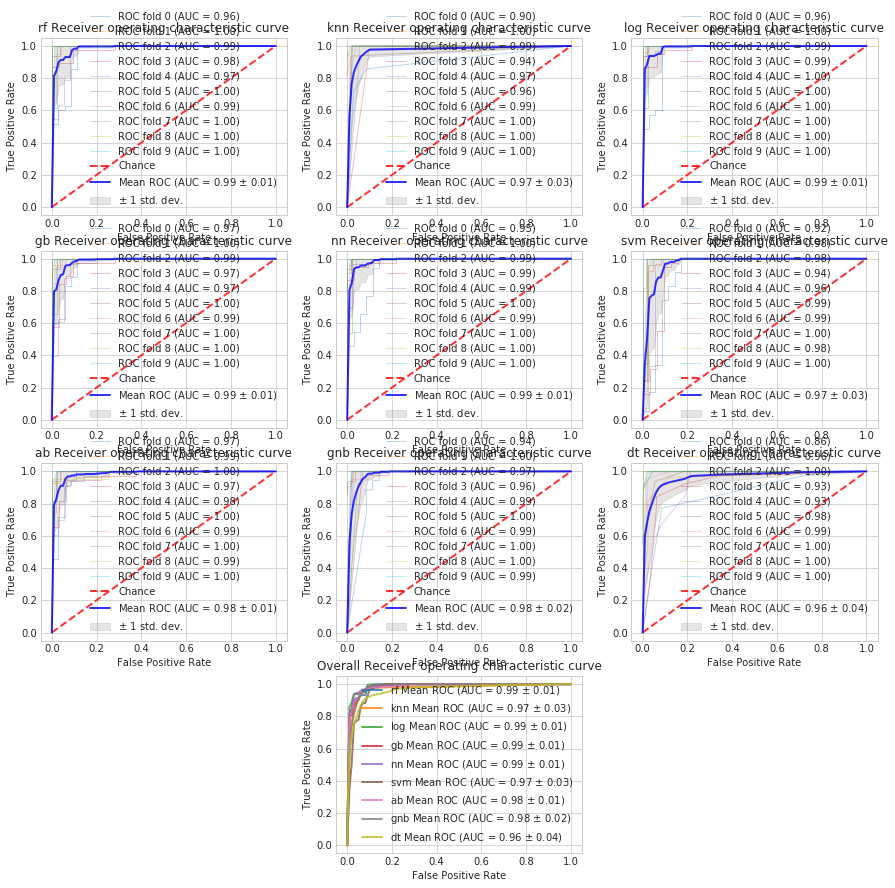

In [53]:
plt_id = 1
plt.figure(figsize=(15,15))
for name, m in models.items():
    ax = plt.subplot(4,3,plt_id)
    fpr, tpr, auc_mean, auc_std = plot_roc_curve(name, m, X, y)
    plt_id+=1
    
    ax = plt.subplot(4,3,11)
    plt.plot(fpr, tpr, label=name + r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (auc_mean, auc_std),
             lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [50]:
resultDF.to_csv('results.csv',index=False)

In [51]:
import pickle

In [52]:
for name, m in models.items():
    pickle.dump(m,open(name + '.sav','wb'))